# Classification 3

Regression is so useful it would be shame if we couldn't use it for classification. Thankfully, we can.

In [1]:
from pandas import Series, DataFrame
import pandas as pd
from patsy import dmatrices
%pylab inline

Populating the interactive namespace from numpy and matplotlib


We will look at a dataset of marriages and affairs (inspired by [this analysis](http://nbviewer.ipython.org/github/justmarkham/gadsdc1/blob/master/logistic_assignment/kevin_logistic_sklearn.ipynb)).

In [2]:
df = pd.read_csv('Classification_3_data/affairs.csv')
df.columns.values

array(['rate_marriage', 'age', 'yrs_married', 'children', 'religious',
       'educ', 'occupation', 'occupation_husb', 'affairs'], dtype=object)

* **rate_marriage**: a woman's rating of her marriage; between 1 and 5, with 1 being worst and 5 being best
* **religious**: woman's rating of how religious she is (1 = not religious, 4 = strongly religious)
* **occupation**: woman's occupation
    * 1 = student
    * 2 = farming/semi-skilled/unskilled
    * 3 = "white collar"
    * 4 = teacher/nurse/writer/technician/skilled
    * 5 = managerial/business
    * 6 = professional with advanced degree
* **occupation_husb**: ditto for husband
* **affairs**: measure of time spent in extra-marital affairs

In [3]:
df.iloc[0]

rate_marriage       3.000000
age                32.000000
yrs_married         9.000000
children            3.000000
religious           3.000000
educ               17.000000
occupation          2.000000
occupation_husb     5.000000
affairs             0.111111
Name: 0, dtype: float64

Let us convert **affairs** into a binary variable, to make it a classification task.

Text(0, 0.5, 'number of women')

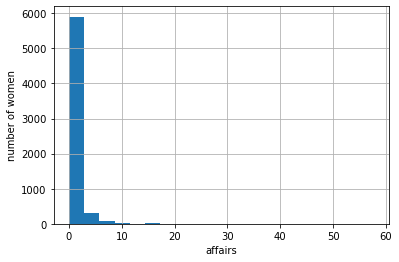

In [4]:
df['affairs'].hist(bins=20)
xlabel('affairs')
ylabel('number of women')

Seems like it is mostly 0 or around 0.0. Let us look up the median.

In [5]:
print(df['affairs'].median())

0.0


So, at least 50% of the women had 0 for affairs.

## Create the target

Let us create a target where affairs > 0 is the positive class, and affairs = 0 is the negative class.

In [6]:
df['target'] = 0.0
df['target'][df['affairs'] > 0] = 1.0
df['target'].value_counts()

0.0    4313
1.0    2053
Name: target, dtype: int64

## Create design matrices

In [7]:
formula = 'target ~ 0 + rate_marriage + age + yrs_married + children ' + \
           ' + religious + educ + C(occupation) + C(occupation_husb)'

We have something new in this formula:

* What is C(occupation) and C(occupation_husb)?

What is C(occupation) and C(occupation_husb)?

* Both of these are **categorical** variables (student/farming/teacher/business, etc.)
* However, they are coded as integers
    * 1 = student
    * 2 = farming, etc.
* We need to tell Python to not think of occupation as **ordered** variables.

In [8]:
Y, X = dmatrices(formula, df, return_type='dataframe')
y = Y['target'].values

## Plot data

Affairs versus rate_marriage?

In [9]:
rating_vs_target = pd.crosstab(df['rate_marriage'], df['target'])
rating_vs_target

target,0.0,1.0
rate_marriage,,
1.0,25,74
2.0,127,221
3.0,446,547
4.0,1518,724
5.0,2197,487


We used the **crosstab** function:

* Very similar to pivot_table
* Create a table of rows='rate_marriage' and cols='target'
* Each cell contains the number of datapoints
    * Cell corresponding to "target=0" and 'rate\_marriage=2.0" has the _number_ of women who rated their marriage as 2.0 and did not have affairs.

Let us normalize each column so that we can compare columns.

In [10]:
total_ratings = rating_vs_target.apply(sum)
total_ratings

target
0.0    4313
1.0    2053
dtype: int64

In [11]:
rating_vs_target /= total_ratings
rating_vs_target

target,0.0,1.0
rate_marriage,,
1.0,0.005796,0.036045
2.0,0.029446,0.107647
3.0,0.103408,0.266439
4.0,0.351959,0.352655
5.0,0.509390,0.237214


* This table contains, for each marriage rating,
    * the _fraction_ of marriages in the positive class, and
    * the _fraction_ in the negative class

* These are precisely the **Naive Bayes** tables we had seen in the last class.

<AxesSubplot:xlabel='rate_marriage'>

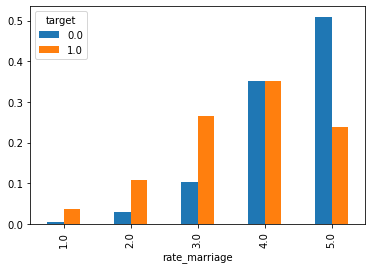

In [12]:
rating_vs_target.plot(kind='bar')

* When marriage rating is low (e.g., 1 and 2), target=1.0 (had affair) is much more likely.
* When marriage rating is high (e.g., 5), target=0.0 (no affair) is more likely.
* We expect to see this in the trained classifier as well.

## Split the data into training and testing sets

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

## Fit the classifier

In [14]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
result = model.fit(X_train, y_train)

C:\Users\deepay\Miniconda\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [15]:
from sklearn import metrics

prediction_train = model.predict(X_train)
print(metrics.accuracy_score(y_train, prediction_train))

0.7228456014362658


### Accuracy on test set

In [16]:
prediction = model.predict(X_test)
print(metrics.accuracy_score(y_test, prediction))

0.7293193717277487


Pretty much what we expected from accuracy on the training set.

But what is baseline accuracy?

Baseline = predict the most frequent class

In [17]:
# y_train is 0 or 1.
print('Number of positive examples =', len(y_train[y_train==1]))
print('Number of negative examples =', len(y_train[y_train==0]))

Number of positive examples = 1442
Number of negative examples = 3014


Hence, baseline will be _always predicting the negative class_.

In [18]:
negative_examples_in_test = len(y_test[y_test==0])
total_examples_in_test = len(y_test)

print('Number of examples where baseline is correct =', negative_examples_in_test)
print('Baseline accuracy =', negative_examples_in_test * 1.0 / total_examples_in_test)

Number of examples where baseline is correct = 1299
Baseline accuracy = 0.6801047120418848


## Feature weights

What are the weights of each feature?

In [19]:
model.coef_

array([[-0.39546935,  0.33482409,  0.68349887,  0.41972593,  1.02523605,
         0.3760292 ,  0.31868361,  0.4523348 ,  0.33175291,  0.33364574,
         0.46924202, -0.67630866, -0.06371394,  0.11524592, -0.02264607,
        -0.36811034,  0.01401862]])

In [20]:
# And the model intercept
model.intercept_

array([2.52956772])

Let us put these coefficients (i.e., the slopes) in a Series indexed by the feature names.

In [21]:
weights = Series(model.coef_[0],
                 index=X.columns.values)
weights.sort_values()

rate_marriage               -0.676309
C(occupation)[1.0]          -0.395469
religious                   -0.368110
age                         -0.063714
children                    -0.022646
educ                         0.014019
yrs_married                  0.115246
C(occupation_husb)[T.2.0]    0.318684
C(occupation_husb)[T.4.0]    0.331753
C(occupation_husb)[T.5.0]    0.333646
C(occupation)[2.0]           0.334824
C(occupation)[6.0]           0.376029
C(occupation)[4.0]           0.419726
C(occupation_husb)[T.3.0]    0.452335
C(occupation_husb)[T.6.0]    0.469242
C(occupation)[3.0]           0.683499
C(occupation)[5.0]           1.025236
dtype: float64

**Observations**

* rate_marriage has a **negative** weight
    * a higher rating (higher $\Rightarrow$ more satisfied with marriage)
    * means less likely to have affair (target=0 more likely)
* **occupation=5 and 6** has high positive weight $\Rightarrow$ more likely to have affair
    * These corresponds to... 'managerial/business' and 'professional with advanced degree'
    * Life lessons, folks :-)
* Curiously, **occupation_husb** doesn't seem to be as highly weighted.